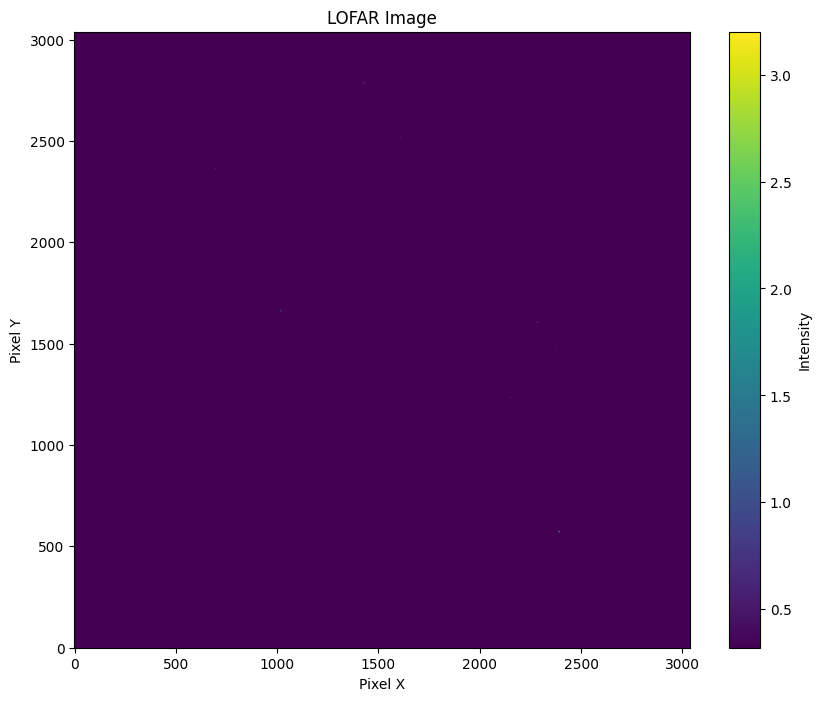

In [4]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
# Specify the path to your FITS file
fits_file_path = '/mnt/c/Users/calsifer/Desktop/RGC/data/P114+27-mosaic.fits'

# Load the FITS file
with fits.open(fits_file_path) as hdul:
    # Get the image data from the first HDU (Header/Data Unit)
    image_data = hdul[0].data

# Normalize the image data for better visibility
image_data = np.nan_to_num(image_data)  # Replace NaNs with zero
image_data_min = np.min(image_data)
image_data_max = np.max(image_data)

# Optional: Clip values to a specific range for better contrast
# You can adjust these values based on the data characteristics
clip_min = 0.1 * image_data_max  
clip_max = image_data_max
image_data = np.clip(image_data, clip_min, clip_max)

# Display the image using Matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(image_data, cmap='viridis', origin='lower', vmin=clip_min, vmax=clip_max)
plt.colorbar(label='Intensity')
plt.title('LOFAR Image')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.show()


In [5]:
with fits.open(fits_file_path) as hdul:
    # Display the header of the first HDU (Header Data Unit)
    header = hdul[0].header  # Assuming the data is in the first HDU
    data = hdul[0].data  # Load the data from the first HDU

    # Print the header information
    print("FITS Header Information:")
    print(header)

    # Print the dimensions of the data
    print("\nData Dimensions:")
    print(data.shape)  # This will give you the dimensions of the data array

FITS Header Information:
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 3040                                                  NAXIS2  =                 3040                                                  WCSAXES =                    2                                                  CTYPE1  = 'RA---SIN'                                                            CTYPE2  = 'DEC--SIN'                                                            CUNIT1  = 'deg     '                                                            CUNIT2  = 'deg     '                                                            CRPIX1  =                 1520                                                  CRPIX2  =                 1520                                                  CRVAL1  =      

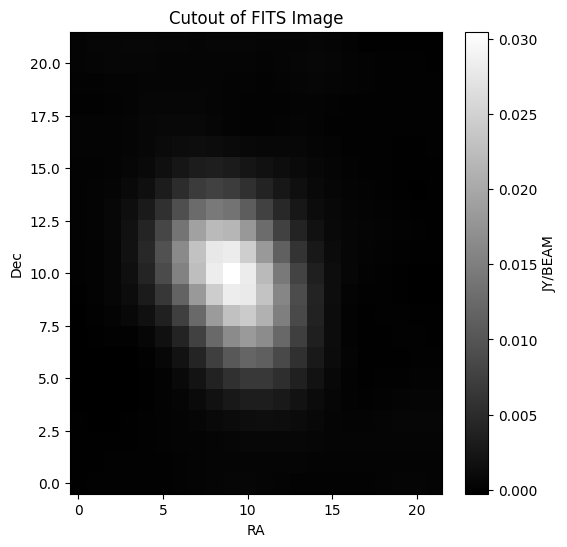

In [6]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt


# RA and Dec in hh:mm:ss and dd:mm:ss format
ra_center = "07 41 01.20"  # RA in hours, minutes, seconds
dec_center = "+26 20 36.6"  # Dec in degrees, minutes, seconds

# Cutout size in arcseconds
cutout_size_arcsec = 100  # Update with the desired cutout size in arcseconds

# Open the FITS file and load data and header
with fits.open(fits_file_path) as hdul:
    data = hdul[0].data
    header = hdul[0].header
    
    # Initialize the WCS from the FITS header
    wcs = WCS(header)
    
    # Define the cutout center using SkyCoord in (hms dms) format
    cutout_center = SkyCoord(ra=ra_center, dec=dec_center, unit=(u.hourangle, u.deg), frame='icrs')
    
    # Define the cutout size in degrees and pixels
    cutout_size_deg = (cutout_size_arcsec / 3600) * u.deg
    cutout_size_pixels = (cutout_size_deg / abs(header['CDELT1'])).value  # Convert to pixels
    
    # Make the cutout
    cutout = Cutout2D(data, cutout_center, size=cutout_size_pixels, wcs=wcs)

    # Plot the cutout
    plt.figure(figsize=(6, 6))
    plt.imshow(cutout.data, origin='lower', cmap='gray', aspect='auto')
    plt.colorbar(label=header['BUNIT'])
    plt.title('Cutout of FITS Image')
    plt.xlabel('RA')
    plt.ylabel('Dec')
    plt.show()

    # Optionally save the cutout as a new FITS file
    # cutout_hdu = fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header())
    # cutout_hdu.writeto('/path/to/save/cutout_image.fits', overwrite=True)


In [14]:
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import os


csv_file_path = '/mnt/c/Users/calsifer/Desktop/RGC/matched_targets_test.csv'  # CSV file path
input_directory = '/mnt/c/Users/calsifer/Desktop/RGC/data/'  # Directory with existing FITS files
output_directory = '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/'  # Directory to save cutout files

# Ensure output directory exists
os.makedirs(output_directory, exist_ok=True)

# Load the CSV file
targets = pd.read_csv(csv_file_path)

# Define the cutout size in arcseconds
cutout_size_arcsec = 400  # Update with the desired size

# Loop over each target
for idx, row in targets.iterrows():
    # Extract the name for the new file, RA, Dec, and existing FITS filename base using .iloc[]
    new_file_name = row.iloc[0]        # New name for the cutout
    ra_hms = row.iloc[1]               # RA in "HH MM SS" format
    dec_dms = row.iloc[2]              # Dec in "±DD MM SS" format
    existing_file_name = f"{row.iloc[5]}-mosaic.fits"  # Existing FITS file name in the 6th column
    
    # Define the output path for the new cutout FITS file
    output_path = os.path.join(output_directory, f"{new_file_name}_cutout.fits")

    # Skip if cutout already exists
    if os.path.exists(output_path):
        print(f"Cutout for '{new_file_name}' already exists. Skipping.")
        continue
    
    # Convert RA/Dec from "HH MM SS" and "±DD MM SS" to degrees
    try:
        sky_coord = SkyCoord(ra_hms, dec_dms, unit=(u.hourangle, u.deg), frame='icrs')
    except ValueError:
        print(f"Invalid RA/Dec format for target '{new_file_name}'. Skipping.")
        continue
    
    # Construct the path to the existing FITS file
    fits_file_path = os.path.join(input_directory, existing_file_name)
    
    # Check if the existing FITS file is available
    if not os.path.exists(fits_file_path):
        print(f"File not found: {fits_file_path}. Skipping target '{new_file_name}'")
        continue

    # Open the existing FITS file
    try:
        with fits.open(fits_file_path) as hdul:
            data = hdul[0].data
            header = hdul[0].header
            wcs = WCS(header)
            
            # Define the cutout center as the converted SkyCoord object
            cutout_center = sky_coord
            
            # Calculate cutout size in degrees and pixels
            cutout_size_deg = (cutout_size_arcsec / 3600) * u.deg
            cutout_size_pixels = (cutout_size_deg / abs(header['CDELT1'])).value
            
            # Get dimensions from the data shape
            naxis1, naxis2 = data.shape
            
            # Check if the cutout center is within the image bounds
            if (cutout_center.ra.deg < wcs.wcs.crval[0] - (naxis1 * abs(header['CDELT1']) / 2) or
                cutout_center.ra.deg > wcs.wcs.crval[0] + (naxis1 * abs(header['CDELT1']) / 2) or
                cutout_center.dec.deg < wcs.wcs.crval[1] - (naxis2 * abs(header['CDELT2']) / 2) or
                cutout_center.dec.deg > wcs.wcs.crval[1] + (naxis2 * abs(header['CDELT2']) / 2)):
                print(f"Cutout center '{new_file_name}' is out of bounds. Skipping.")
                continue
            
            # Attempt to create the cutout
            cutout = Cutout2D(data, cutout_center, size=cutout_size_pixels, wcs=wcs)

            # Save the cutout as a new FITS file
            cutout_hdu = fits.PrimaryHDU(data=cutout.data, header=cutout.wcs.to_header())
            cutout_hdu.writeto(output_path, overwrite=True)
            
            print(f"Saved cutout for '{new_file_name}' to '{output_path}'")

    except Exception as e:
        print(f"Error processing '{new_file_name}': {e}")


Saved cutout for 'J0754+3951' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0754+3951_cutout.fits'
Saved cutout for 'J0726+3102' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0726+3102_cutout.fits'
Saved cutout for 'J0734+2933' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0734+2933_cutout.fits'
Saved cutout for 'J0741+2620' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0741+2620_cutout.fits'
Saved cutout for 'J0752+3750' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0752+3750_cutout.fits'
Cutout center 'J0757+5824' is out of bounds. Skipping.
Saved cutout for 'J0813+4347' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0813+4347_cutout.fits'
Saved cutout for 'J0814+4300' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0814+4300_cutout.fits'
Saved cutout for 'J0815+3840' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0815+3840_cutout.fits'
Cutout center 'J0816+5716' is out of bounds. Skipping.
Saved cutout for 'J0818+49

Saved cutout for 'J0738+3846' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0738+3846_cutout.fits'
Saved cutout for 'J0743+2710' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0743+2710_cutout.fits'
Saved cutout for 'J0803+3951' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0803+3951_cutout.fits'
Saved cutout for 'J0819+2522' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0819+2522_cutout.fits'
Cutout center 'J0819+5746' is out of bounds. Skipping.
Saved cutout for 'J0824+5200' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0824+5200_cutout.fits'
Saved cutout for 'J0827+3820' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0827+3820_cutout.fits'
Cutout center 'J0828+2436' is out of bounds. Skipping.
Saved cutout for 'J0829+6322' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0829+6322_cutout.fits'
Saved cutout for 'J0834+3945' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J0834+3945_cutout.fits'
Cutout center 'J0844+2538'

Saved cutout for 'J1137+3000' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1137+3000_cutout.fits'
Saved cutout for 'J1152+4229' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1152+4229_cutout.fits'
Saved cutout for 'J1202+5801' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1202+5801_cutout.fits'
Saved cutout for 'J1208+3425' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1208+3425_cutout.fits'
Cutout center 'J1209+5715' is out of bounds. Skipping.
Saved cutout for 'J1215+3243' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1215+3243_cutout.fits'
Saved cutout for 'J1225+3737' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1225+3737_cutout.fits'
Saved cutout for 'J1227+4928' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1227+4928_cutout.fits'
Saved cutout for 'J1231+3850' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/J1231+3850_cutout.fits'
Saved cutout for 'J1234+4012' to '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_da

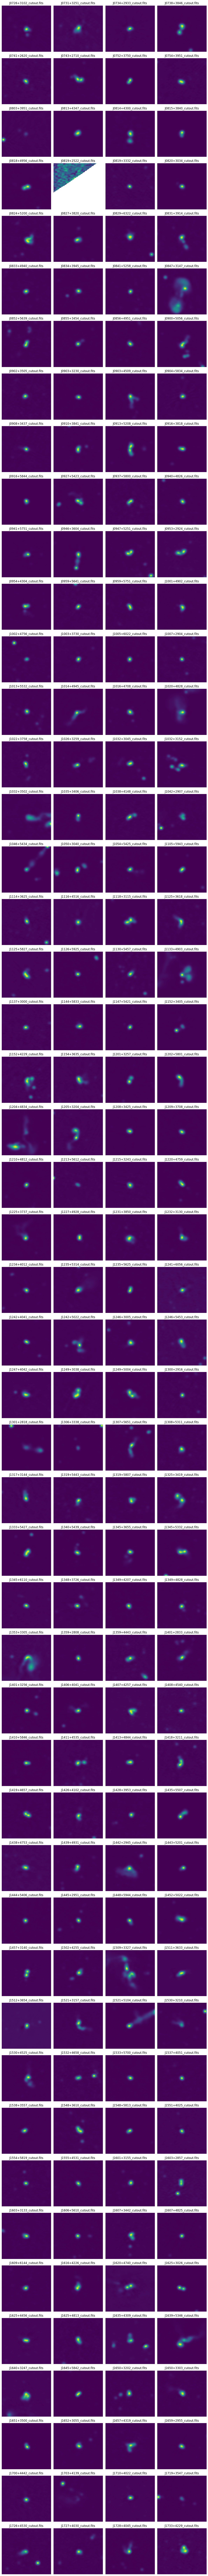

In [15]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits

# Path to the directory containing the cutout FITS files
cutout_directory = '/mnt/c/Users/calsifer/Desktop/RGC/400arc_cut_data/'

# List all FITS files in the directory
fits_files = [f for f in os.listdir(cutout_directory) if f.endswith('.fits')]

# Determine the number of images to display
num_images = len(fits_files)

# Determine the layout for the subplots
ncols = 4  # Number of columns for the subplot
nrows = (num_images // ncols) + (num_images % ncols > 0)  # Calculate rows needed

# Set up a plotting environment
plt.figure(figsize=(12, 3 * nrows))  # Adjust height based on the number of rows

# Loop through each FITS file and display the image
for idx, fits_file in enumerate(fits_files):
    # Construct the full path to the FITS file
    fits_file_path = os.path.join(cutout_directory, fits_file)
    
    # Open the FITS file
    with fits.open(fits_file_path) as hdul:
        data = hdul[0].data  # Get the data from the first HDU
        
        # Plot the image
        plt.subplot(nrows, ncols, idx + 1)  # Create subplot based on calculated rows and columns
        plt.imshow(data, cmap='viridis', origin='lower', aspect='auto')
        plt.title(fits_file)
        plt.axis('off')  # Hide the axes for a cleaner view

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


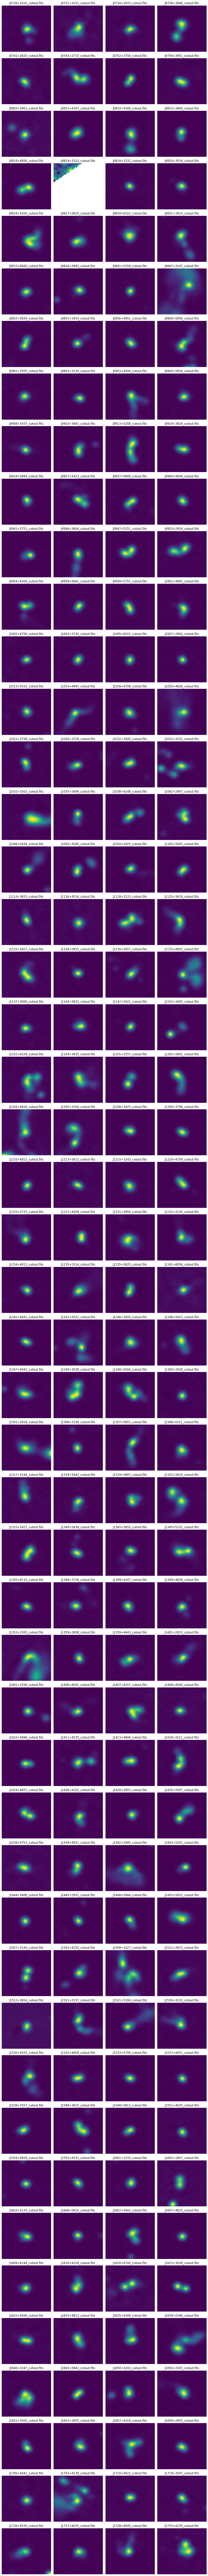

In [1]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits

# Path to the directory containing the cutout FITS files
cutout_directory = '/mnt/c/Users/calsifer/Desktop/RGC/200arc_cut_data/'

# List all FITS files in the directory
fits_files = [f for f in os.listdir(cutout_directory) if f.endswith('.fits')]

# Determine the number of images to display
num_images = len(fits_files)

# Determine the layout for the subplots
ncols = 4  # Number of columns for the subplot
nrows = (num_images // ncols) + (num_images % ncols > 0)  # Calculate rows needed

# Set up a plotting environment
plt.figure(figsize=(12, 3 * nrows))  # Adjust height based on the number of rows

# Loop through each FITS file and display the image
for idx, fits_file in enumerate(fits_files):
    # Construct the full path to the FITS file
    fits_file_path = os.path.join(cutout_directory, fits_file)
    
    # Open the FITS file
    with fits.open(fits_file_path) as hdul:
        data = hdul[0].data  # Get the data from the first HDU
        
        # Plot the image
        plt.subplot(nrows, ncols, idx + 1)  # Create subplot based on calculated rows and columns
        plt.imshow(data, cmap='viridis', origin='lower', aspect='auto')
        plt.title(fits_file)
        plt.axis('off')  # Hide the axes for a cleaner view

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
